In [16]:
import pandas as pd
pd.set_option('display.max_columns', None)

import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib.ticker import FixedLocator
from matplotlib.ticker import FixedFormatter
from sklearn.metrics import silhouette_samples
from fcmeans import FCM

from seaborn import scatterplot as scatter
from sklearn.metrics import silhouette_score
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import roc_curve, roc_auc_score

sns.set()
register_matplotlib_converters()

In [17]:
df_raw = pd.read_csv("compas-scores-raw.csv")

In [18]:
df_raw["name"] = df_raw["FirstName"] + " " + df_raw["LastName"]

df_raw["DateOfBirth"] = pd.to_datetime(df_raw["DateOfBirth"], format="%m/%d/%y")
df_raw

,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,ScaleSet_ID,ScaleSet,AssessmentReason,Language,LegalStatus,CustodyStatus,MaritalStatus,Screening_Date,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted,name
0,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,1992-12-05,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,7,Risk of Violence,-2.08,4,Low,New,1,0,Kevin Fisher
1,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,1992-12-05,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,8,Risk of Recidivism,-1.06,2,Low,New,1,0,Kevin Fisher
2,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,1992-12-05,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/1/13 0:00,1,Low,18,Risk of Failure to Appear,15.00,1,Low,New,1,0,Kevin Fisher
3,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,1984-09-16,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Married,1/1/13 0:00,1,Low,7,Risk of Violence,-2.84,2,Low,New,1,0,KEVIN KENDALL
4,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,1984-09-16,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Married,1/1/13 0:00,1,Low,8,Risk of Recidivism,-1.50,1,Low,New,1,0,KEVIN KENDALL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60838,65667,79665,72038,Probation,West,James,NaN,Male,African-American,2064-06-21,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,12/31/14 0:00,3,Medium with Override Consideration,8,Risk of Recidivism,0.16,8,High,New,1,0,James West
60839,65667,79665,72038,Probation,West,James,NaN,Male,African-American,2064-06-21,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,12/31/14 0:00,3,Medium with Override Consideration,18,Risk of Failure to Appear,35.00,10,High,New,1,0,James West
60840,68603,79669,72042,PRETRIAL,Ryan,Michael,NaN,Male,Caucasian,1985-02-06,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,12/31/14 0:00,1,Low,7,Risk of Violence,-2.75,2,Low,New,1,0,Michael Ryan
60841,68603,79669,72042,PRETRIAL,Ryan,Michael,NaN,Male,Caucasian,1985-02-06,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,12/31/14 0:00,1,Low,8,Risk of Recidivism,-0.34,5,Medium,New,1,0,Michael Ryan


In [19]:
df_two = pd.read_csv("compas-scores-two-years.csv")

In [20]:
df_two["dob"] = pd.to_datetime(df_two["dob"], format="%Y-%m-%d")
df_two

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,2013-01-12,NaN,1.0,F,Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,2013-01-13,Risk of Violence,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,0,1,0,0,2,NaN,NaN,NaN,12014130CF10A,NaN,2013-01-09,76.0,F,arrest case no charge,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-03-26,Risk of Violence,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,0,7,0,0,0,-1.0,2013-11-22 05:18:27,2013-11-24 02:59:20,13016249CF10A,2013-11-22,NaN,1.0,F,Deliver Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,7,Medium,2013-11-23,Risk of Violence,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,0,3,0,0,0,-1.0,2014-01-31 07:13:54,2014-02-02 04:03:52,14001422CF10A,2014-01-31,NaN,1.0,F,Leaving the Scene of Accident,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,3,Low,2014-02-01,Risk of Violence,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,0,1,0,0,0,-1.0,2014-01-13 05:48:01,2014-01-14 07:49:46,14000581CF10A,2014-01-13,NaN,1.0,F,Aggravated Battery / Pregnant,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2014-01-14,Risk of Violence,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,0,2,0,0,3,-1.0,2014-03-08 08:06:02,2014-03-09 12:18:04,140033

In [21]:
df_raw['name']=df_raw['name'].str.lower()
merged_df = pd.merge(df_two, df_raw, left_on=['name', 'dob'], right_on=['name', 'DateOfBirth'], how='inner')


In [22]:
merged_df

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,ScaleSet_ID,ScaleSet,AssessmentReason,Language,LegalStatus,CustodyStatus,MaritalStatus,Screening_Date,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
0,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,51601,58102,52796,PRETRIAL,DIXON,KEVON,NaN,Male,African-American,1982-01-22,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/27/13 0:00,1,Low,7,Risk of Violence,-3.07,1,Low,New,1,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,51601,58102,52796,PRETRIAL,DIXON,KEVON,NaN,Male,African-American,1982-01-22,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/27/13 0:00,1,Low,8,Risk of Recidivism,-0.76,3,Low,New,1,0
2,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,51601,58102,52796,PRETRIAL,DIXON,KEVON,NaN,Male,African-American,1982-01-22,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/27/13 0:00,1,Low,18,Risk of Failure to Appear,25.00,6,Medium,New,1,0
3,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1,38864,61042,55421,PRETRIAL,Philo,Ed,NaN,Male,African-American,1991-05-14,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,4/14/13 0:00,1,Low,7,Risk of Violence,-2.26,3,Low,New,1,0
4,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1,38864,61042,55421,PRETRIAL,

In [23]:
#peszeudonomizálás

drop_columns = ['LastName','FirstName','MiddleName','name','first','last']
merged_df = merged_df.drop(columns = drop_columns)


In [24]:
#duplikáció

merged_df=merged_df.drop_duplicates()

In [25]:
merged_df

,id,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,Person_ID,AssessmentID,Case_ID,Agency_Text,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,ScaleSet_ID,ScaleSet,AssessmentReason,Language,LegalStatus,CustodyStatus,MaritalStatus,Screening_Date,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
0,3,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,51601,58102,52796,PRETRIAL,Male,African-American,1982-01-22,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/27/13 0:00,1,Low,7,Risk of Violence,-3.07,1,Low,New,1,0
1,3,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,51601,58102,52796,PRETRIAL,Male,African-American,1982-01-22,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/27/13 0:00,1,Low,8,Risk of Recidivism,-0.76,3,Low,New,1,0
2,3,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,51601,58102,52796,PRETRIAL,Male,African-American,1982-01-22,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,1/27/13 0:00,1,Low,18,Risk of Failure to Appear,25.00,6,Medium,New,1,0
3,4,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1,38864,61042,55421,PRETRIAL,Male,African-American,1991-05-14,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,4/14/13 0:00,1,Low,7,Risk of Violence,-2.26,3,Low,New,1,0
4,4,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,0,4,0,1,4,-1.0,2013-04-13 04:58:34,2013-04-14 07:02:04,13005330CF10A,2013-04-13,NaN,1.0,F,Possession of Cocaine,1,13011511MM10A,(M1),0.0,2013-06-16,Driving Under The Influence,2013-06-16,2013-06-16,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,2013-04-14,Risk of Violence,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1,38864,61042,55421,PRETRIAL,Male,African-American,1991-05-14,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,4/14/13 0:00,1,Low,8,Risk of Recidivism,-0.66,4,Low,New,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [26]:
merged_df = merged_df[
    (merged_df['days_b_screening_arrest'] >= -30.0) & 
    (30.0 >= merged_df['days_b_screening_arrest']) & 
    (merged_df['is_recid'] != -1) &
    (merged_df['c_charge_degree'] != "O") &
    (merged_df['score_text']!= 'N/A')
]

merged_df = merged_df.loc[merged_df.groupby('Person_ID')['screening_date'].idxmax()]
merged_df = merged_df.dropna(subset=["ScoreText"])

In [27]:
merged_df.head(5)

,id,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,Person_ID,AssessmentID,Case_ID,Agency_Text,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,ScaleSet_ID,ScaleSet,AssessmentReason,Language,LegalStatus,CustodyStatus,MaritalStatus,Screening_Date,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
552,302,2014-07-13,Female,1981-01-20,35,25 - 45,African-American,0,9,1,0,23,-1.0,2014-07-12 03:02:54,2014-07-14 05:19:00,14009552CF10A,2014-07-12,NaN,1.0,F,Felony Petit Theft,1,15006897CF10A,(F3),NaN,2015-05-27,Felony Petit Theft,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,9,High,2014-07-13,Risk of Violence,9,High,2014-07-13,2014-07-12,2014-07-14,23,1,318,1,1,656,74859,350,Broward County,Female,African-American,1981-01-20,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,7/13/14 0:00,4,High,7,Risk of Violence,-0.67,9,High,Copy,1,0
17277,9710,2014-07-20,Male,1988-11-25,27,25 - 45,African-American,0,5,0,0,8,-1.0,2014-07-19 11:52:29,2014-08-14 05:28:51,14011045CF10A,2014-07-19,NaN,1.0,F,Felony Battery w/Prior Convict,1,14014315CF10A,(F3),56.0,2014-09-02,Felony Battery (Dom Strang),2014-10-28,2015-01-27,NaN,1,14014315CF10A,(F3),2014-09-02,Felony Battery (Dom Strang),Risk of Recidivism,5,Medium,2014-07-20,Risk of Violence,6,Medium,2014-07-20,2014-07-19,2014-08-14,8,25,44,1,1,667,75075,67999,Broward County,Male,African-American,1988-11-25,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,7/20/14 0:00,2,Medium,7,Risk of Violence,-1.55,6,Medium,New,1,0
12945,7312,2014-04-06,Male,1990-05-02,25,25 - 45,Caucasian,0,8,1,0,6,0.0,2014-04-06 02:30:39,2014-04-06 07:45:48,14004746CF10A,2014-04-05,NaN,1.0,F,Crim Use of Personal ID Info,1,16001768MM10A,(M1),NaN,2016-01-11,Battery,NaN,NaN,NaN,1,16001768MM10A,(M1),2016-01-11,Battery,Risk of Recidivism,8,High,2014-04-06,Risk of Violence,6,Medium,2014-04-06,2014-04-06,2014-04-06,6,0,645,1,1,737,71931,430,PRETRIAL,Male,Caucasian,1990-05-02,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,4/6/14 0:00,3,Medium with Override Consideration,7,Risk of Violence,-1.63,6,Medium,Copy,1,0
14781,8304,2013-09-26,Female,1988-07-14,27,25 - 45,Caucasian,0,10,0,0,6,-1.0,2013-09-25 04:05:03,2013-09-26 08:46:37,13013512CF10A,2013-09-25,NaN,1.0,F,Grand Theft (Motor Vehicle),0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,10,High,2013-09-26,Risk of Violence,9,High,2013-09-26,2014-07-09,2014-07-10,6,0,286,0,0,782,65816,472,PRETRIAL,Female,Caucasian,1988-07-14,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,9/26/13 0:00,4,High,7,Risk of Violence,-0.91,9,High,Copy,1,0
8097,4530,2013-11-27,Male,1990-07-15,25,25 - 45,Other,0,2,0,0,2,0.0,2013-11-27 12:32:45,2013-11-27 02:52:06,13016493CF10A,2013-11-26,NaN,1.0,F,"Poss3,4 Methylenedioxymethcath",0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,2,Low,2013-11-27,Risk of Violence,3,Low,2013-11-27,2015-04-10,2015-04-11,2,0,499,0,0,869,67920,562,PRETRIAL,Male,Other,1990-07-15,22,Risk and Prescreen,Intake,English,Pretrial,Jail Inmate,Single,11/27/13 0:00,1,Low,7,Risk of Violence,-2.37,3,Low,Copy,1,0


In [28]:
data = {
    'Group': merged_df['DecileScore'],  # Csoportosítási eredmény (pl. klaszter index)
    'is_recid': merged_df['is_recid']  # is_recid változó értékei
}

df_sum_origin = pd.DataFrame(data)

# Kimutatás készítése: Csoportonkénti is_recid értékek számlálása és átlaga
summary_origin = df_sum_origin.groupby('Group')['is_recid'].agg(['count', 'mean']).reset_index()
summary_origin.columns = ['Group', 'Count', 'Mean_is_recid']

In [29]:
print(summary_origin)

   Group  Count  Mean_is_recid
0      1    850       0.281176
1      2    788       0.416244
2      3    745       0.488591
3      4    623       0.540931
4      5    541       0.591497
5      6    476       0.611345
6      7    363       0.663912
7      8    247       0.777328
8      9    221       0.823529
9     10     95       0.778947


In [30]:

cluster_race_counts = merged_df.groupby(['race', 'DecileScore']).size().reset_index(name='Count')

# Pivot tábla készítése a jobb olvashatóság érdekében
pivot_table = cluster_race_counts.pivot(index='race', columns='DecileScore', values='Count').fillna(0)

# Kimenet megtekintése
print(pivot_table)





DecileScore          1      2      3      4      5      6      7      8   \
race                                                                       
African-American  278.0  369.0  390.0  352.0  318.0  309.0  263.0  184.0   
Asian              10.0    4.0    1.0    4.0    0.0    2.0    0.0    1.0   
Caucasian         361.0  275.0  265.0  194.0  147.0  115.0   72.0   42.0   
Hispanic          114.0   80.0   55.0   39.0   52.0   30.0   14.0   14.0   
Native American     2.0    1.0    0.0    3.0    0.0    0.0    1.0    0.0   
Other              85.0   59.0   34.0   31.0   24.0   20.0   13.0    6.0   

DecileScore          9     10  
race                           
African-American  163.0  72.0  
Asian               0.0   0.0  
Caucasian          39.0  15.0  
Hispanic           11.0   5.0  
Native American     2.0   0.0  
Other               6.0   3.0  


In [31]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(f"{fig_id}.{fig_extension}", format=fig_extension, dpi=resolution)

Saving figure white_vs_black


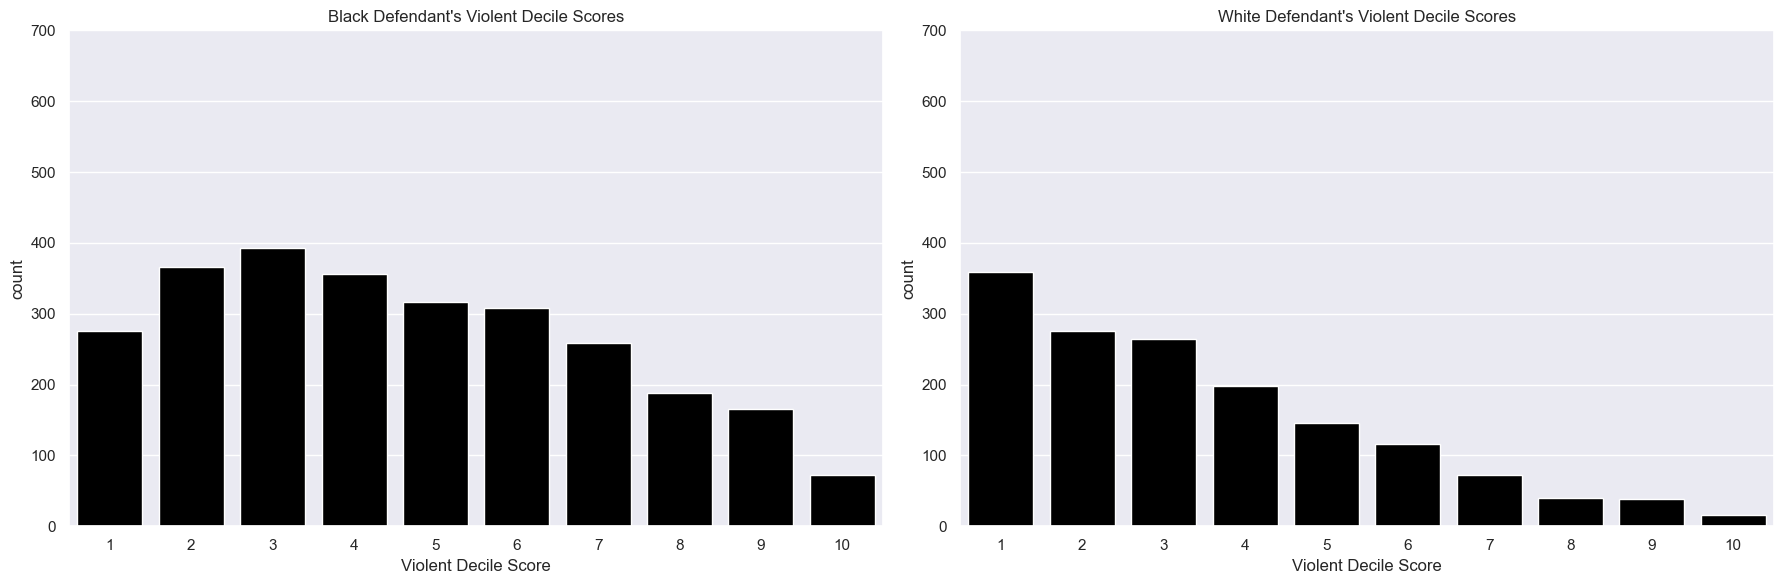

In [32]:

df_black = merged_df[merged_df['race'] == "African-American"]
df_white = merged_df[merged_df['race'] == "Caucasian"]


fig, axes = plt.subplots(ncols=2, figsize=(18, 6))

sns.countplot(data=df_black, x='v_decile_score', ax=axes[0],color='black')
axes[0].set_title("Black Defendant's Violent Decile Scores")
axes[0].set_xlabel("Violent Decile Score")
axes[0].set_ylim(0, 700)

sns.countplot(data=df_white, x='v_decile_score', ax=axes[1],color='black')
axes[1].set_title("White Defendant's Violent Decile Scores")
axes[1].set_xlabel("Violent Decile Score")
axes[1].set_ylim(0, 700)

plt.tight_layout()
save_fig("white_vs_black", tight_layout=True)
plt.show()

In [33]:
def t(tn, fp, fn, tp):
    # Számítások
    surv = tn + fp  # Survived összesen (True Negative + False Positive)
    recid = tp + fn  # Recidivated összesen (True Positive + False Negative)
    
    # Kiírás
    print("           \tLow\tHigh")
    print(f"Survived   \t{tn}\t{fp}\t{surv / (surv + recid):.2f}")
    print(f"Recidivated\t{fn}\t{tp}\t{recid / (surv + recid):.2f}")
    print(f"Total: {surv + recid:.2f}")
    
    # Statisztikai mutatók
    fpr = fp / surv * 100  # False Positive Rate
    fnr = fn / recid * 100  # False Negative Rate
    spec = tn / (tn + fp)  # Specificity
    sens = tp / (tp + fn)  # Sensitivity
    ppv = tp / (tp + fp)  # Positive Predictive Value (PPV)
    npv = tn / (tn + fn)  # Negative Predictive Value (NPV)
    prev = recid / (surv + recid)  # Prevalence
    try:
        lr_plus = sens / (1 - spec)
    except ZeroDivisionError:
        lr_plus = float('inf')  # Vagy valami más, pl. None
    lr_minus = (1 - sens) / spec  # Likelihood Ratio Negative (LR-)
    
    # Kiírás
    print(f"False positive rate: {fpr:.2f}%")
    print(f"False negative rate: {fnr:.2f}%")
    print(f"Specificity: {spec:.2f}")
    print(f"Sensitivity: {sens:.2f}")
    print(f"Prevalence: {prev:.2f}")
    print(f"PPV: {ppv:.2f}")
    print(f"NPV: {npv:.2f}")
    print(f"LR+: {lr_plus:.2f}")
    print(f"LR-: {lr_minus:.2f}")



In [34]:
# Segédfüggvény: count, amely megszámolja az elemeket egy listában, amely megfelel egy feltételnek
def count(predicate, iterable):
    return sum(1 for item in iterable if predicate(item))

# table függvény
def table(recid, surv, prefix=''):
    # True Negative (TN): alacsony kockázatúak és túlélték
    tn = count(lambda i: getattr(i, prefix + 'low'), surv)
    # False Positive (FP): magas kockázatúak, de túlélték
    fp = count(lambda i: getattr(i, prefix + 'high'), surv)
    # False Negative (FN): alacsony kockázatúak, de visszaestek
    fn = count(lambda i: getattr(i, prefix + 'low'), recid)
    # True Positive (TP): magas kockázatúak és visszaestek
    tp = count(lambda i: getattr(i, prefix + 'high'), recid)
    
    # Hívjuk meg a t() függvényt az adatokkal
    t(tn, fp, fn, tp)

# Példa adatok (recid és surv listák)
class Defendant:
    def __init__(self, low, high):
        self.low = low
        self.high = high


In [35]:
tp = merged_df[(merged_df['DecileScore'] > 5) & (merged_df['is_recid'] == 1)].shape[0]
tn = merged_df[(6 > merged_df['DecileScore']) & (merged_df['is_recid'] == 0)].shape[0]
fp = merged_df[(merged_df['DecileScore'] > 5) & (merged_df['is_recid'] == 0)].shape[0]
fn= merged_df[(6 > merged_df['DecileScore']) & (merged_df['is_recid'] == 1)].shape[0]

In [36]:
t(tn, fp,fn, tp)

           	Low	High
Survived   	1959	422	0.48
Recidivated	1588	980	0.52
Total: 4949.00
False positive rate: 17.72%
False negative rate: 61.84%
Specificity: 0.82
Sensitivity: 0.38
Prevalence: 0.52
PPV: 0.70
NPV: 0.55
LR+: 2.15
LR-: 0.75


In [37]:
white_df = merged_df[merged_df['race'] == 'Caucasian']

In [38]:
tp = white_df[(white_df['DecileScore'] > 5) & (white_df['is_recid'] == 1)].shape[0]
tn = white_df[(6 > white_df['DecileScore']) & (white_df['is_recid'] == 0)].shape[0]
fp = white_df[(white_df['DecileScore'] > 5) & (white_df['is_recid'] == 0)].shape[0]
fn= white_df[(6 > white_df['DecileScore']) & (white_df['is_recid'] == 1)].shape[0]

t(tn, fp,fn, tp)

           	Low	High
Survived   	712	100	0.53
Recidivated	530	183	0.47
Total: 1525.00
False positive rate: 12.32%
False negative rate: 74.33%
Specificity: 0.88
Sensitivity: 0.26
Prevalence: 0.47
PPV: 0.65
NPV: 0.57
LR+: 2.08
LR-: 0.85


In [39]:
black_df = merged_df[merged_df['race'] == 'African-American']

In [40]:
tp = black_df[(black_df['DecileScore'] > 5) & (black_df['is_recid'] == 1)].shape[0]
tn = black_df[(6 > black_df['DecileScore']) & (black_df['is_recid'] == 0)].shape[0]
fp = black_df[(black_df['DecileScore'] > 5) & (black_df['is_recid'] == 0)].shape[0]
fn= black_df[(6 > black_df['DecileScore']) & (black_df['is_recid'] == 1)].shape[0]

t(tn, fp,fn, tp)

           	Low	High
Survived   	860	275	0.42
Recidivated	847	716	0.58
Total: 2698.00
False positive rate: 24.23%
False negative rate: 54.19%
Specificity: 0.76
Sensitivity: 0.46
Prevalence: 0.58
PPV: 0.72
NPV: 0.50
LR+: 1.89
LR-: 0.72


In [41]:
not_biased_columns = ['age','juv_fel_count', 'juv_misd_count', 'juv_other_count','priors_count','days_b_screening_arrest','c_charge_degree','c_charge_desc','r_charge_degree','r_days_from_arrest','r_offense_date','violent_recid','vr_charge_degree','vr_offense_date','in_custody','out_custody','event','race']

biased_but_needed_columns = ['sex', 'race', 'MaritalStatus', "CustodyStatus", 'LegalStatus','two_year_recid','DecileScore']

merged_colums = ['age','juv_fel_count', 'juv_misd_count', 'juv_other_count','priors_count','days_b_screening_arrest','c_charge_degree','c_charge_desc','is_recid','r_charge_degree','r_days_from_arrest','r_offense_date','violent_recid','vr_charge_degree','vr_offense_date','in_custody','out_custody','event','two_year_recid','sex', 'race', 'MaritalStatus', "CustodyStatus", 'LegalStatus','DecileScore','is_recid']

In [42]:
df = merged_df[not_biased_columns]

In [43]:
df['r_offense_date'] = pd.to_datetime(df['r_offense_date'])
df['in_custody'] = pd.to_datetime(df['in_custody'])
df['vr_offense_date'] = pd.to_datetime(df['vr_offense_date'])
df['out_custody'] = pd.to_datetime(df['out_custody'])


df['r_offense_date'] = pd.to_numeric(df['r_offense_date'], errors='coerce').fillna(0).astype(int)
df['in_custody'] = pd.to_numeric(df['in_custody'], errors='coerce').fillna(0).astype(int)
df['vr_offense_date'] = pd.to_numeric(df['vr_offense_date'], errors='coerce').fillna(0).astype(int)
df['out_custody'] = pd.to_numeric(df['out_custody'], errors='coerce').fillna(0).astype(int)


C:\Users\molar\AppData\Local\Temp\ipykernel_5964\2562195509.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['r_offense_date'] = pd.to_datetime(df['r_offense_date'])
C:\Users\molar\AppData\Local\Temp\ipykernel_5964\2562195509.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['in_custody'] = pd.to_datetime(df['in_custody'])
C:\Users\molar\AppData\Local\Temp\ipykernel_5964\2562195509.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [44]:
df['days_b_screening_arrest'] = df['days_b_screening_arrest'].astype(int)

C:\Users\molar\AppData\Local\Temp\ipykernel_5964\767232123.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['days_b_screening_arrest'] = df['days_b_screening_arrest'].astype(int)


In [45]:
df

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_charge_degree,c_charge_desc,r_charge_degree,r_days_from_arrest,r_offense_date,violent_recid,vr_charge_degree,vr_offense_date,in_custody,out_custody,event,race
552,35,0,1,0,23,-1,F,Felony Petit Theft,(F3),NaN,588906496,NaN,NaN,0,296288256,877068288,1,African-American
17277,27,0,0,0,8,-1,F,Felony Battery w/Prior Convict,(F3),56.0,-1783300096,NaN,(F3),-1783300096,181534720,-858259456,1,African-American
12945,25,0,1,0,6,0,F,Crim Use of Personal ID Info,(M1),NaN,516227072,NaN,(M1),516227072,45744128,45744128,1,Caucasian
14781,27,0,0,0,6,-1,F,Grand Theft (Motor Vehicle),NaN,NaN,0,NaN,NaN,0,1572601856,-284491776,0,Caucasian
8097,25,0,0,0,2,0,F,"Poss3,4 Methylenedioxymethcath",NaN,NaN,0,NaN,NaN,0,1972961280,115867648,0,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15240,30,0,0,0,0,-1,F,Possession of Cocaine,(F3),1.0,1061945344,NaN,NaN,0,-2071461888,-781123584,1,African-American
12459,26,0,1,0,6,-1,F,Poss Pyrrolidinovalerophenone,(F3),1.0,1492910080,NaN,(F3),1492910080,-1877016576,-715456512,1,African-American
13260,30,0,0,0,3,-1,M,Battery,(F3),0.0,-572653568,NaN,NaN,0,-572653568,1865220096,1,Hispanic
10560,34,0,0,0,0,-1,F,Poss Pyrrolidinovalerophenone,(F3),NaN,-1841954816,NaN,NaN,0,560857088,-1174470656,1,Caucasian


In [46]:
print(df.dtypes)

age                          int64
juv_fel_count                int64
juv_misd_count               int64
juv_other_count              int64
priors_count                 int64
days_b_screening_arrest      int32
c_charge_degree             object
c_charge_desc               object
r_charge_degree             object
r_days_from_arrest         float64
r_offense_date               int32
violent_recid              float64
vr_charge_degree            object
vr_offense_date              int32
in_custody                   int32
out_custody                  int32
event                        int64
race                        object
dtype: object


In [47]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
label_encoders = {}
for column in ['c_charge_degree', 'c_charge_desc', 'r_charge_degree', 'vr_charge_degree','race']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column].astype(str))
    label_encoders[column] = le

# NaN értékek kezelése (itt nullára állítjuk)
df = df.fillna(0)


C:\Users\molar\AppData\Local\Temp\ipykernel_5964\2872027040.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = le.fit_transform(df[column].astype(str))
C:\Users\molar\AppData\Local\Temp\ipykernel_5964\2872027040.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = le.fit_transform(df[column].astype(str))
C:\Users\molar\AppData\Local\Temp\ipykernel_5964\2872027040.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [48]:
scaled_df = preprocessing.scale(df)

C:\Users\molar\anaconda3\Lib\site-packages\sklearn\preprocessing\_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


In [49]:
var_ratio = 2
pca = PCA(n_components=var_ratio)
pca.fit(scaled_df)
pca_data = pca.transform(scaled_df)

loading_scores = pd.Series(pca.components_[0])
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)

loadings = pd.Series(loading_scores)
factors = pd.Series(df.columns)
print(pd.concat([loadings, factors], axis=1))

           0                        1
0  -0.125957                      age
1   0.173619            juv_fel_count
2   0.253755           juv_misd_count
3   0.201331          juv_other_count
4   0.365445             priors_count
5   0.080138  days_b_screening_arrest
6  -0.184821          c_charge_degree
7   0.141998            c_charge_desc
8  -0.519364          r_charge_degree
9   0.107608       r_days_from_arrest
10  0.021227           r_offense_date
11 -0.000000            violent_recid
12 -0.347182         vr_charge_degree
13  0.054897          vr_offense_date
14  0.006447               in_custody
15 -0.004096              out_custody
16  0.457227                    event
17 -0.200842                     race


Első modell

In [50]:
fcm = FCM(n_clusters=10, random_state=42, max_iter=2)
fcm.fit(scaled_df)

fcm_centers = fcm.centers
u = pd.DataFrame(fcm.u)
fcm_labels  = fcm.u.argmax(axis=1)

y_pred_fuzzy = fcm.predict(scaled_df) +1

print("FCM predikciók")
print(fcm.u[:10])
print()
print("Becsült értékek")
for i in range(10):
    print(y_pred_fuzzy[i])

FCM predikciók
[[0.09973193 0.10013339 0.09996385 0.09990586 0.10010071 0.10017638
  0.0999495  0.09986045 0.10022109 0.09995684]
 [0.09981954 0.10003168 0.09999091 0.09986087 0.10011299 0.10027562
  0.10001559 0.0999192  0.10002909 0.09994452]
 [0.09909861 0.10009828 0.10005904 0.09995109 0.10011441 0.10061028
  0.09978024 0.10013503 0.10020033 0.09995269]
 [0.10047984 0.09945428 0.0998963  0.10042698 0.09996444 0.09914949
  0.10001995 0.1002903  0.10060406 0.09971437]
 [0.10005196 0.09975921 0.10019696 0.1002283  0.10003797 0.09962821
  0.09998418 0.10016047 0.10001909 0.09993364]
 [0.09952923 0.10011592 0.10002517 0.10002915 0.1001895  0.10042111
  0.09954318 0.10008968 0.10005355 0.10000352]
 [0.10048345 0.10005416 0.0996478  0.09958594 0.09994867 0.0997816
  0.10033259 0.09983846 0.10037843 0.09994891]
 [0.0999255  0.10008424 0.0999528  0.0998655  0.10004811 0.10007062
  0.09998635 0.09991958 0.1001521  0.0999952 ]
 [0.10002631 0.10026132 0.09983632 0.09939742 0.10001525 0.1002413

In [51]:
y_true = merged_df['DecileScore']

In [52]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(scaled_df, fcm_labels)

print("Silhouette Score for Fuzzy C-Means Clustering:", sil_score)

Silhouette Score for Fuzzy C-Means Clustering: -0.020219309691292577


In [53]:
data = {
    'Group': y_pred_fuzzy,  # Csoportosítási eredmény (pl. klaszter index)
    'is_recid': merged_df['is_recid']  # is_recid változó értékei
}

df_sum = pd.DataFrame(data)

# Kimutatás készítése: Csoportonkénti is_recid értékek számlálása és átlaga
summary = df_sum.groupby('Group')['is_recid'].agg(['count', 'mean']).reset_index()
summary.columns = ['Group', 'Count', 'Mean_is_recid']

summary_sorted = summary.sort_values(by='Mean_is_recid', ascending=True).reset_index(drop=True)

# Új csoportsorszám hozzáadása a rendezett adatok alapján
summary_sorted['New_Group'] = summary_sorted.index + 1

# Eredmény megtekintése
print(summary_sorted)

   Group  Count  Mean_is_recid  New_Group
0      1   1848       0.036255          1
1      8     69       0.275362          2
2     10     38       0.315789          3
3      4    496       0.385081          4
4      7    367       0.732970          5
5      9    460       0.782609          6
6      3     97       0.814433          7
7      5     30       0.900000          8
8      2    184       1.000000          9
9      6   1360       1.000000         10


In [54]:
group_mapping = dict(zip(summary_sorted['Group'], summary_sorted['New_Group']))

# Ezt a térképet használjuk az y_pred_fuzzy értékek átírására
y_pred_fuzzy_mapped = np.array([group_mapping[group] for group in y_pred_fuzzy])

In [55]:
df_c = df.copy()
df_c['DecileScore'] = y_pred_fuzzy_mapped
for column, le in label_encoders.items():
    df_c[column] = le.inverse_transform(df_c[column])
cluster_race_counts = df_c.groupby(['race', 'DecileScore']).size().reset_index(name='Count')

# Pivot tábla készítése a jobb olvashatóság érdekében
pivot_table = cluster_race_counts.pivot(index='race', columns='DecileScore', values='Count').fillna(0)

# Kimenet megtekintése
print(pivot_table)



DecileScore          1     2     3      4      5      6     7     8     9   \
race                                                                         
African-American  872.0  16.0   3.0  281.0  250.0  384.0   5.0   5.0  77.0   
Asian              14.0   0.0   0.0    1.0    0.0    1.0   0.0   0.0   1.0   
Caucasian         663.0  31.0   6.0  156.0   95.0   64.0  24.0  11.0  79.0   
Hispanic          198.0   8.0   6.0   39.0   20.0   10.0  14.0   5.0  17.0   
Native American     5.0   0.0   0.0    0.0    0.0    0.0   0.0   1.0   1.0   
Other              96.0  14.0  23.0   19.0    2.0    1.0  54.0   8.0   9.0   

DecileScore          10  
race                     
African-American  805.0  
Asian               5.0  
Caucasian         396.0  
Hispanic           97.0  
Native American     2.0  
Other              55.0  


In [56]:
df_c['is_recid'] = merged_df['is_recid']

In [57]:
tp = df_c[(df_c['DecileScore'] > 5) & (df_c['is_recid'] == 1)].shape[0]
tn = df_c[(6 > df_c['DecileScore']) & (df_c['is_recid'] == 0)].shape[0]
fp = df_c[(df_c['DecileScore'] > 5) & (df_c['is_recid'] == 0)].shape[0]
fn= df_c[(6 > df_c['DecileScore']) & (df_c['is_recid'] == 1)].shape[0]

In [58]:
t(tn, fp, fn, tp)

           	Low	High
Survived   	2260	121	0.48
Recidivated	558	2010	0.52
Total: 4949.00
False positive rate: 5.08%
False negative rate: 21.73%
Specificity: 0.95
Sensitivity: 0.78
Prevalence: 0.52
PPV: 0.94
NPV: 0.80
LR+: 15.40
LR-: 0.23


In [59]:
white_df = df_c[df_c['race'] == 'Caucasian']

In [60]:
tp = white_df[(white_df['DecileScore'] > 5) & (white_df['is_recid'] == 1)].shape[0]
tn = white_df[(6 > white_df['DecileScore']) & (white_df['is_recid'] == 0)].shape[0]
fp = white_df[(white_df['DecileScore'] > 5) & (white_df['is_recid'] == 0)].shape[0]
fn= white_df[(6 > white_df['DecileScore']) & (white_df['is_recid'] == 1)].shape[0]
t(tn, fp, fn, tp)

           	Low	High
Survived   	794	18	0.53
Recidivated	157	556	0.47
Total: 1525.00
False positive rate: 2.22%
False negative rate: 22.02%
Specificity: 0.98
Sensitivity: 0.78
Prevalence: 0.47
PPV: 0.97
NPV: 0.83
LR+: 35.18
LR-: 0.23


In [61]:
black_df = df_c[df_c['race'] == 'African-American']

In [62]:
tp = black_df[(black_df['DecileScore'] > 5) & (black_df['is_recid'] == 1)].shape[0]
tn = black_df[(6 > black_df['DecileScore']) & (black_df['is_recid'] == 0)].shape[0]
fp = black_df[(black_df['DecileScore'] > 5) & (black_df['is_recid'] == 0)].shape[0]
fn= black_df[(6 > black_df['DecileScore']) & (black_df['is_recid'] == 1)].shape[0]
t(tn, fp, fn, tp)

           	Low	High
Survived   	1058	77	0.42
Recidivated	364	1199	0.58
Total: 2698.00
False positive rate: 6.78%
False negative rate: 23.29%
Specificity: 0.93
Sensitivity: 0.77
Prevalence: 0.58
PPV: 0.94
NPV: 0.74
LR+: 11.31
LR-: 0.25


Saving figure white_vs_black_fuzzy


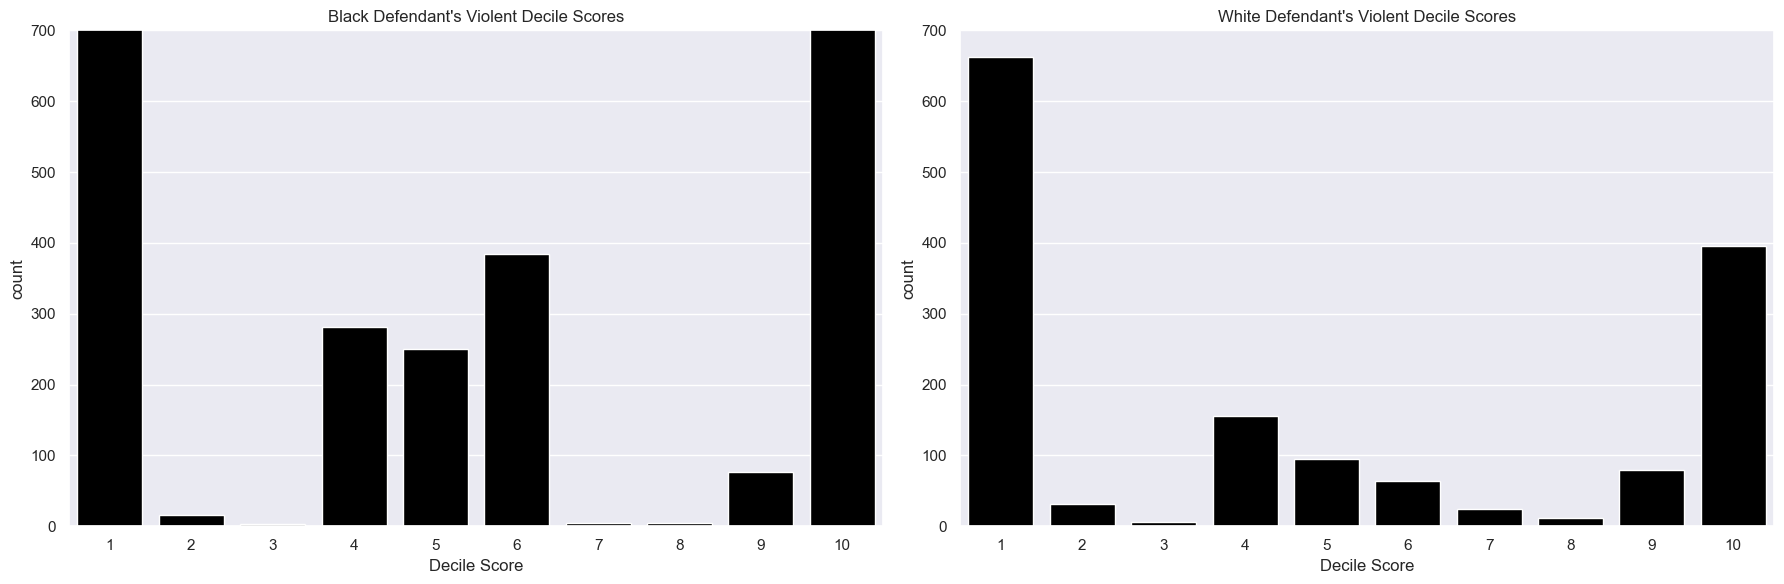

In [63]:


fig, axes = plt.subplots(ncols=2, figsize=(18, 6))

sns.countplot(data=black_df, x='DecileScore', ax=axes[0],color='black')
axes[0].set_title("Black Defendant's Violent Decile Scores")
axes[0].set_xlabel("Decile Score")
axes[0].set_ylim(0, 700)

sns.countplot(data=white_df, x='DecileScore', ax=axes[1],color='black')
axes[1].set_title("White Defendant's Violent Decile Scores")
axes[1].set_xlabel("Decile Score")
axes[1].set_ylim(0, 700)

plt.tight_layout()
save_fig("white_vs_black_fuzzy", tight_layout=True)
plt.show()

Második modell

In [64]:
kmeans = KMeans(n_clusters=10, init='random', n_init=100, max_iter=1000, random_state=42)
kmeans.fit(scaled_df)
y_pred = kmeans.predict(scaled_df)+1

y_pred[:30]

array([ 7, 10,  9,  4,  4,  7,  2, 10,  2,  7,  2,  5,  2,  4,  8,  6,  7,
        5,  6,  7,  6,  4,  1,  2,  7,  6,  4,  6,  8,  4])

In [65]:
kmeans_sil_score = silhouette_score(scaled_df, y_pred)

print("Silhouette Score for KMeans Clustering:", kmeans_sil_score)

Silhouette Score for KMeans Clustering: 0.11098165543678233


In [66]:
data = {
    'Group': y_pred,  # Csoportosítási eredmény (pl. klaszter index)
    'is_recid': merged_df['is_recid']  # is_recid változó értékei
}

df_sum = pd.DataFrame(data)

# Kimutatás készítése: Csoportonkénti is_recid értékek számlálása és átlaga
summary = df_sum.groupby('Group')['is_recid'].agg(['mean']).reset_index()
summary.columns = ['Group', 'Mean_is_recid']


summary_sorted = summary.sort_values(by='Mean_is_recid', ascending=True).reset_index(drop=True)

# Új csoportsorszám hozzáadása a rendezett adatok alapján
summary_sorted['New_Group'] = summary_sorted.index + 1

# Eredmény megtekintése
print(summary_sorted)

   Group  Mean_is_recid  New_Group
0      5       0.096241          1
1      4       0.128450          2
2      6       0.139059          3
3      8       0.419162          4
4      1       0.814815          5
5      2       1.000000          6
6      3       1.000000          7
7      7       1.000000          8
8      9       1.000000          9
9     10       1.000000         10


In [67]:
group_mapping = dict(zip(summary_sorted['Group'], summary_sorted['New_Group']))

# Ezt a térképet használjuk az y_pred_fuzzy értékek átírására
y_pred_kmeans_mapped = np.array([group_mapping[group] for group in y_pred])

In [68]:
df_c = df.copy()
df_c['DecileScore'] = y_pred_kmeans_mapped

for column, le in label_encoders.items():
    df_c[column] = le.inverse_transform(df_c[column])


cluster_race_counts = df_c.groupby(['race', 'DecileScore']).size().reset_index(name='Count')

# Pivot tábla készítése a jobb olvashatóság érdekében
pivot_table = cluster_race_counts.pivot(index='race', columns='DecileScore', values='Count').fillna(0)

# Kimenet megtekintése
print(pivot_table)



DecileScore          1      2      3     4     5      6     7      8      9   \
race                                                                           
African-American  263.0  591.0  378.0  70.0  89.0  489.0  33.0  473.0  175.0   
Asian               6.0    2.0    8.0   0.0   0.0    3.0   0.0    1.0    0.0   
Caucasian         250.0  257.0  375.0  72.0  14.0  215.0  18.0  202.0   65.0   
Hispanic           71.0   61.0  130.0  19.0   2.0   51.0   3.0   49.0   12.0   
Native American     3.0    0.0    4.0   0.0   0.0    0.0   1.0    0.0    0.0   
Other              72.0   31.0   83.0   6.0   3.0   24.0   1.0   32.0   13.0   

DecileScore          10  
race                     
African-American  137.0  
Asian               2.0  
Caucasian          57.0  
Hispanic           16.0  
Native American     1.0  
Other              16.0  


In [69]:
df_c['is_recid'] = merged_df['is_recid']
tp = df_c[(df_c['DecileScore'] > 5) & (df_c['is_recid'] == 1)].shape[0]
tn = df_c[(6 > df_c['DecileScore']) & (df_c['is_recid'] == 0)].shape[0]
fp = df_c[(df_c['DecileScore'] > 5) & (df_c['is_recid'] == 0)].shape[0]
fn= df_c[(6 > df_c['DecileScore']) & (df_c['is_recid'] == 1)].shape[0]
t(tn, fp, fn, tp)

           	Low	High
Survived   	2381	0	0.48
Recidivated	479	2089	0.52
Total: 4949.00
False positive rate: 0.00%
False negative rate: 18.65%
Specificity: 1.00
Sensitivity: 0.81
Prevalence: 0.52
PPV: 1.00
NPV: 0.83
LR+: inf
LR-: 0.19


In [70]:
white_df = df_c[df_c['race'] == 'Caucasian']
tp = white_df[(white_df['DecileScore'] > 5) & (white_df['is_recid'] == 1)].shape[0]
tn = white_df[(6 > white_df['DecileScore']) & (white_df['is_recid'] == 0)].shape[0]
fp = white_df[(white_df['DecileScore'] > 5) & (white_df['is_recid'] == 0)].shape[0]
fn= white_df[(6 > white_df['DecileScore']) & (white_df['is_recid'] == 1)].shape[0]
t(tn, fp, fn, tp)

           	Low	High
Survived   	812	0	0.53
Recidivated	156	557	0.47
Total: 1525.00
False positive rate: 0.00%
False negative rate: 21.88%
Specificity: 1.00
Sensitivity: 0.78
Prevalence: 0.47
PPV: 1.00
NPV: 0.84
LR+: inf
LR-: 0.22


In [71]:
black_df = df_c[df_c['race'] == 'African-American']
tp = black_df[(black_df['DecileScore'] > 5) & (black_df['is_recid'] == 1)].shape[0]
tn = black_df[(6 > black_df['DecileScore']) & (black_df['is_recid'] == 0)].shape[0]
fp = black_df[(black_df['DecileScore'] > 5) & (black_df['is_recid'] == 0)].shape[0]
fn= black_df[(6 > black_df['DecileScore']) & (black_df['is_recid'] == 1)].shape[0]
t(tn, fp, fn, tp)

           	Low	High
Survived   	1135	0	0.42
Recidivated	256	1307	0.58
Total: 2698.00
False positive rate: 0.00%
False negative rate: 16.38%
Specificity: 1.00
Sensitivity: 0.84
Prevalence: 0.58
PPV: 1.00
NPV: 0.82
LR+: inf
LR-: 0.16


Saving figure white_vs_black_kmeans


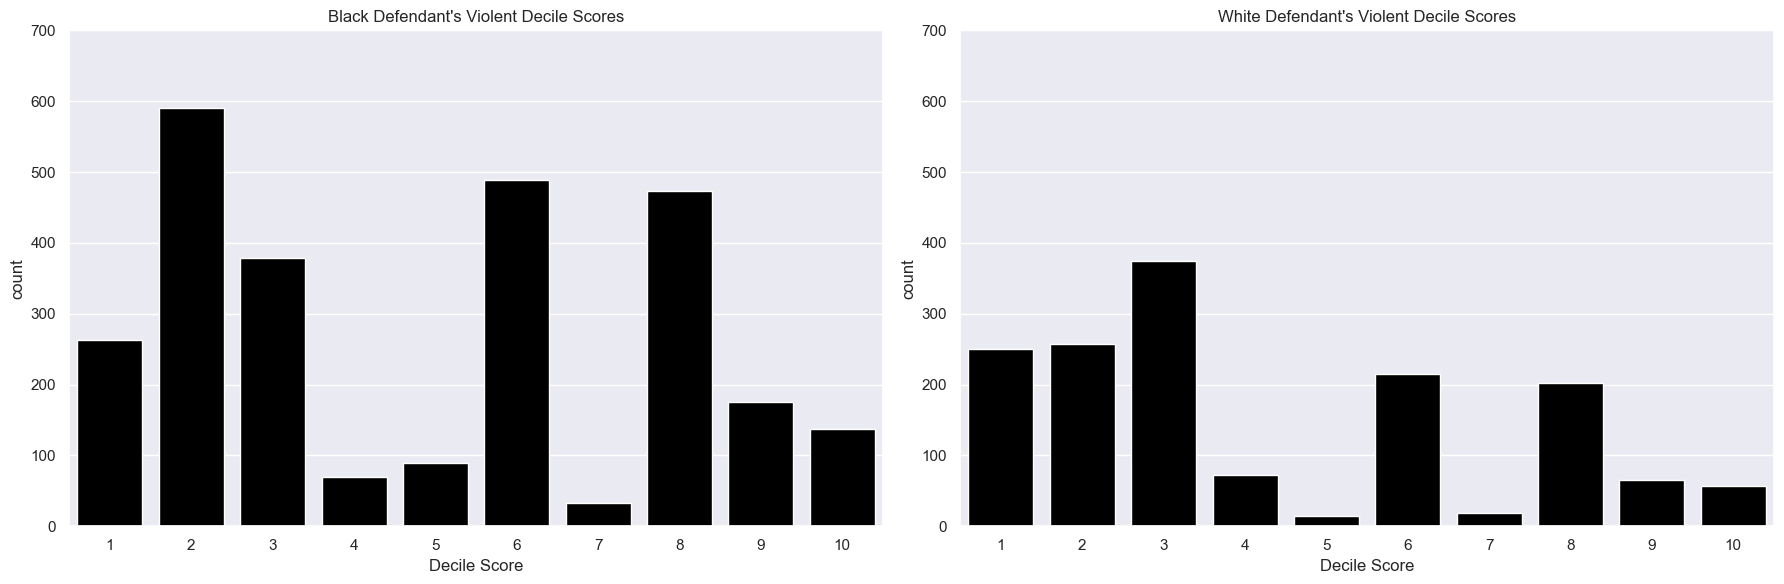

In [72]:


fig, axes = plt.subplots(ncols=2, figsize=(18, 6))

sns.countplot(data=black_df, x='DecileScore', ax=axes[0],color='black')
axes[0].set_title("Black Defendant's Violent Decile Scores")
axes[0].set_xlabel("Decile Score")
axes[0].set_ylim(0, 700)

sns.countplot(data=white_df, x='DecileScore', ax=axes[1],color='black')
axes[1].set_title("White Defendant's Violent Decile Scores")
axes[1].set_xlabel("Decile Score")
axes[1].set_ylim(0, 700)

plt.tight_layout()
save_fig("white_vs_black_kmeans", tight_layout=True)
plt.show()

Autoencoder

K-means

In [73]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd

# 1. Adatok skálázása, ha még nem történt meg
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df)

# 2. Autoencoder felépítése
input_dim = scaled_df.shape[1]  # Az input dimenziók
input_layer = layers.Input(shape=(input_dim,))
encoded = layers.Dense(128, activation='relu')(input_layer)
encoded = layers.Dense(64, activation='relu')(encoded)
bottleneck = layers.Dense(32, activation='relu')(encoded)  # Bottleneck

decoded = layers.Dense(64, activation='relu')(bottleneck)
decoded = layers.Dense(128, activation='relu')(decoded)
output_layer = layers.Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = models.Model(inputs=input_layer, outputs=output_layer)

# 3. Modell betanítása
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(scaled_df, scaled_df, epochs=50, batch_size=32, verbose=0)

# 4. Encoder modell létrehozása a tömörített adatokhoz
encoder = models.Model(inputs=input_layer, outputs=bottleneck)
compressed_data = encoder.predict(scaled_df)

# 5. KMeans futtatása a tömörített adatokon
kmeans = KMeans(n_clusters=10, init='random', n_init=100, max_iter=1000, random_state=42)
kmeans.fit(compressed_data)
y_pred_auto_k = kmeans.predict(compressed_data) + 1


155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [74]:
kmeansplus_sil_score_auto = silhouette_score(scaled_df, y_pred_auto_k)

print("Silhouette Score for KMeans Clustering:", kmeansplus_sil_score_auto)

Silhouette Score for KMeans Clustering: 0.09417854543296762


In [75]:
data = {
    'Group': y_pred_auto_k,  # Csoportosítási eredmény (pl. klaszter index)
    'is_recid': merged_df['is_recid']  # is_recid változó értékei
}

df_sum = pd.DataFrame(data)

# Kimutatás készítése: Csoportonkénti is_recid értékek számlálása és átlaga
summary = df_sum.groupby('Group')['is_recid'].agg(['mean']).reset_index()
summary.columns = ['Group', 'Mean_is_recid']
summary_sorted = summary.sort_values(by='Mean_is_recid', ascending=True).reset_index(drop=True)

# Új csoportsorszám hozzáadása a rendezett adatok alapján
summary_sorted['New_Group'] = summary_sorted.index + 1

# Eredmény megtekintése
print(summary_sorted)

   Group  Mean_is_recid  New_Group
0     10       0.043581          1
1      9       0.070359          2
2      4       0.169753          3
3      7       0.816406          4
4      5       0.964286          5
5      1       0.984334          6
6      6       0.985965          7
7      2       1.000000          8
8      3       1.000000          9
9      8       1.000000         10


In [76]:
group_mapping = dict(zip(summary_sorted['Group'], summary_sorted['New_Group']))

# Ezt a térképet használjuk az y_pred_fuzzy értékek átírására
y_pred_auot_k_mapped = np.array([group_mapping[group] for group in y_pred_auto_k])

In [77]:
df_c = df.copy()
df_c['DecileScore'] = y_pred_auot_k_mapped

for column, le in label_encoders.items():
    df_c[column] = le.inverse_transform(df_c[column])


cluster_race_counts = df_c.groupby(['race', 'DecileScore']).size().reset_index(name='Count')

# Pivot tábla készítése a jobb olvashatóság érdekében
pivot_table = cluster_race_counts.pivot(index='race', columns='DecileScore', values='Count').fillna(0)

# Kimenet megtekintése
print(pivot_table)



DecileScore          1      2      3      4     5      6      7      8   \
race                                                                      
African-American  393.0  793.0   16.0  177.0  21.0  217.0  175.0  325.0   
Asian               8.0    7.0    0.0    0.0   0.0    1.0    2.0    2.0   
Caucasian         338.0  431.0   67.0   67.0   4.0  123.0   68.0  163.0   
Hispanic          110.0  104.0   42.0   12.0   0.0   30.0   21.0   45.0   
Native American     0.0    0.0    5.0    0.0   0.0    0.0    1.0    3.0   
Other               0.0    1.0  194.0    0.0   3.0   12.0   18.0   28.0   

DecileScore          9      10  
race                            
African-American  155.0  426.0  
Asian               0.0    2.0  
Caucasian          54.0  210.0  
Hispanic            9.0   41.0  
Native American     0.0    0.0  
Other              10.0   15.0  


In [78]:
df_c['is_recid'] = merged_df['is_recid']
tp = df_c[(df_c['DecileScore'] > 5) & (df_c['is_recid'] == 1)].shape[0]
tn = df_c[(6 > df_c['DecileScore']) & (df_c['is_recid'] == 0)].shape[0]
fp = df_c[(df_c['DecileScore'] > 5) & (df_c['is_recid'] == 0)].shape[0]
fn= df_c[(6 > df_c['DecileScore']) & (df_c['is_recid'] == 1)].shape[0]
t(tn, fp, fn, tp)

           	Low	High
Survived   	2371	10	0.48
Recidivated	422	2146	0.52
Total: 4949.00
False positive rate: 0.42%
False negative rate: 16.43%
Specificity: 1.00
Sensitivity: 0.84
Prevalence: 0.52
PPV: 1.00
NPV: 0.85
LR+: 198.97
LR-: 0.17


In [79]:
white_df = df_c[df_c['race'] == 'Caucasian']
tp = white_df[(white_df['DecileScore'] > 5) & (white_df['is_recid'] == 1)].shape[0]
tn = white_df[(6 > white_df['DecileScore']) & (white_df['is_recid'] == 0)].shape[0]
fp = white_df[(white_df['DecileScore'] > 5) & (white_df['is_recid'] == 0)].shape[0]
fn= white_df[(6 > white_df['DecileScore']) & (white_df['is_recid'] == 1)].shape[0]
t(tn, fp, fn, tp)

           	Low	High
Survived   	811	1	0.53
Recidivated	96	617	0.47
Total: 1525.00
False positive rate: 0.12%
False negative rate: 13.46%
Specificity: 1.00
Sensitivity: 0.87
Prevalence: 0.47
PPV: 1.00
NPV: 0.89
LR+: 702.67
LR-: 0.13


In [80]:
black_df = df_c[df_c['race'] == 'African-American']
tp = black_df[(black_df['DecileScore'] > 5) & (black_df['is_recid'] == 1)].shape[0]
tn = black_df[(6 > black_df['DecileScore']) & (black_df['is_recid'] == 0)].shape[0]
fp = black_df[(black_df['DecileScore'] > 5) & (black_df['is_recid'] == 0)].shape[0]
fn= black_df[(6 > black_df['DecileScore']) & (black_df['is_recid'] == 1)].shape[0]
t(tn, fp, fn, tp)

           	Low	High
Survived   	1126	9	0.42
Recidivated	274	1289	0.58
Total: 2698.00
False positive rate: 0.79%
False negative rate: 17.53%
Specificity: 0.99
Sensitivity: 0.82
Prevalence: 0.58
PPV: 0.99
NPV: 0.80
LR+: 104.00
LR-: 0.18


Saving figure white_vs_black_auto_k


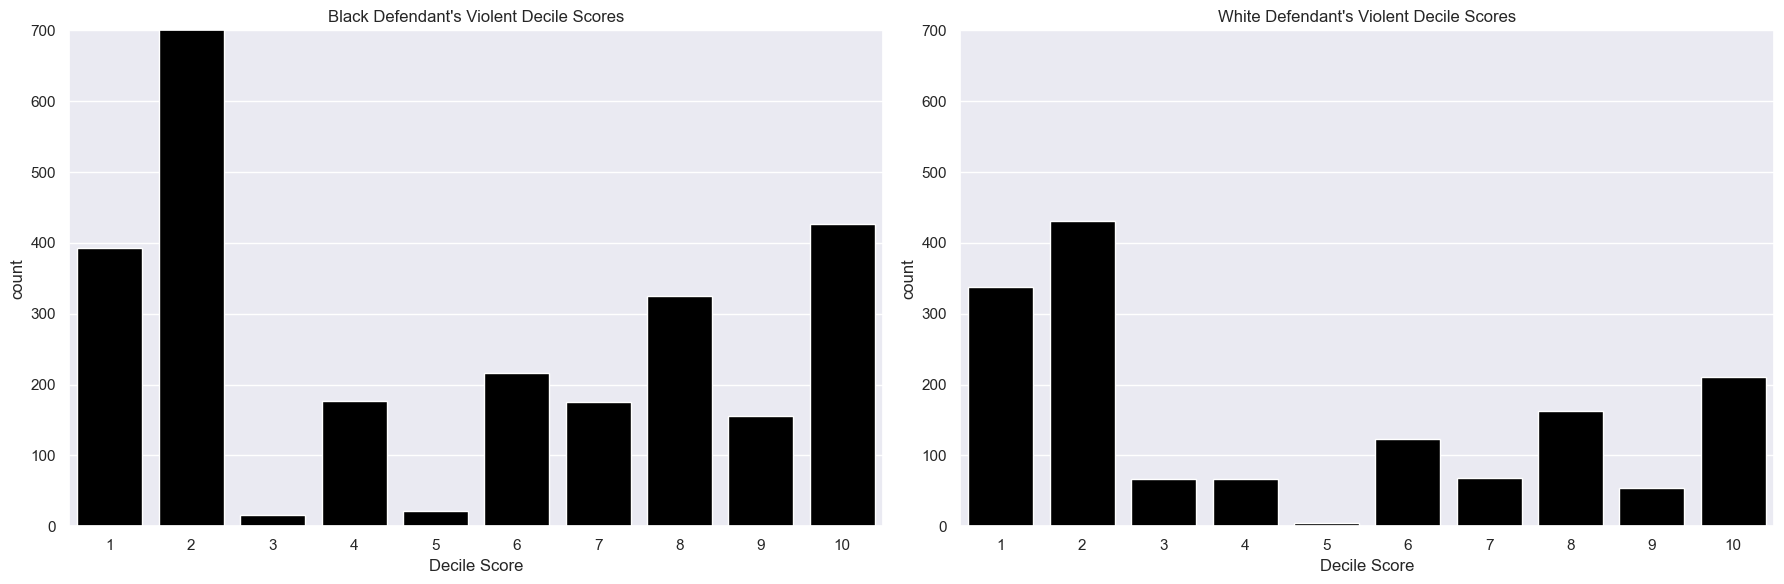

In [81]:


fig, axes = plt.subplots(ncols=2, figsize=(18, 6))

sns.countplot(data=black_df, x='DecileScore', ax=axes[0],color='black')
axes[0].set_title("Black Defendant's Violent Decile Scores")
axes[0].set_xlabel("Decile Score")
axes[0].set_ylim(0, 700)

sns.countplot(data=white_df, x='DecileScore', ax=axes[1],color='black')
axes[1].set_title("White Defendant's Violent Decile Scores")
axes[1].set_xlabel("Decile Score")
axes[1].set_ylim(0, 700)

plt.tight_layout()
save_fig("white_vs_black_auto_k", tight_layout=True)
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

fs = 20  # Font size

# Helper function to create a DataFrame from PCA data
create_pca_frame = lambda pcd: pd.DataFrame(pcd, columns=[str(x) for x in range(pcd.shape[1])])

# PCA-transformed data frame
pca_frame = create_pca_frame(pca_data)
pca_frame['pred'] = pd.Series(y_pred_auto_k)  # Clusters from K-means or Fuzzy C-means

# Scaled data frame (assumed to have the same structure as pca_data)
scaled_frame = create_pca_frame(scaled_df)

# List of column names to be plotted
columns = ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 
           'days_b_screening_arrest', 'c_charge_degree', 'c_charge_desc', 'r_charge_degree', 
           'r_days_from_arrest', 'r_offense_date', 'violent_recid', 'vr_charge_degree', 
           'vr_offense_date', 'in_custody', 'out_custody', 'event', 'race']

# Loop through variables for plotting
for x, y in zip(range(len(columns)), columns):
    pca_frame['pred'] = scaled_frame[str(x)]

    # Ensure the cluster centers have the same number of features as the PCA input
    centers = kmeans.cluster_centers_[:, :pca.n_features_in_]  # Select the first 18 features

# Now, transform the reduced cluster centers using the fitted PCA model
    pca_centers = pd.DataFrame(pca.transform(centers), columns=['0', '1'])


    # Create a plot for each variable
    plt.figure(figsize=(50, 50))
    plt.title(f'PCA, var={y}', fontsize=fs)

    # Plotting the PCA-transformed data with clusters using seaborn
    sns.scatterplot(x='0', y='1', hue='pred', data=pca_frame, palette='deep', s=100)

    # Plotting the PCA-transformed cluster centers
    plt.scatter(x=pca_centers['0'], y=pca_centers['1'], color='red', marker='+', s=200, label='Centers')

    # Customizing axis labels and title
    plt.xlabel('Principal Component 1', fontsize=fs)
    plt.ylabel('Principal Component 2', fontsize=fs)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)

    # Display the plot
    plt.show()

FCM

In [82]:
# 5. FCM futtatása a tömörített adatokon

fcm = FCM(n_clusters=10, random_state=42, max_iter=2)
fcm.fit(compressed_data)

fcm_centers = fcm.centers
u = pd.DataFrame(fcm.u)
fcm_labels  = fcm.u.argmax(axis=1)

y_pred_auto_fcm = fcm.predict(compressed_data) +1




In [83]:
fcm_sil_score_auto = silhouette_score(scaled_df, y_pred_auto_fcm)

print("Silhouette Score for FCM Clustering:", fcm_sil_score_auto)

Silhouette Score for FCM Clustering: -0.007198572987482945


In [84]:
data = {
    'Group': y_pred_auto_fcm,  # Csoportosítási eredmény (pl. klaszter index)
    'is_recid': merged_df['is_recid']  # is_recid változó értékei
}

df_sum = pd.DataFrame(data)

# Kimutatás készítése: Csoportonkénti is_recid értékek számlálása és átlaga
summary = df_sum.groupby('Group')['is_recid'].agg(['mean']).reset_index()
summary.columns = ['Group', 'Mean_is_recid']
summary_sorted = summary.sort_values(by='Mean_is_recid', ascending=True).reset_index(drop=True)

# Új csoportsorszám hozzáadása a rendezett adatok alapján
summary_sorted['New_Group'] = summary_sorted.index + 1

# Eredmény megtekintése
print(summary_sorted)

   Group  Mean_is_recid  New_Group
0      1       0.041756          1
1      7       0.690265          2
2      4       0.716981          3
3      9       0.745763          4
4     10       0.875000          5
5      2       0.950617          6
6      5       0.950630          7
7      3       0.980392          8
8      6       1.000000          9
9      8       1.000000         10


In [85]:
group_mapping = dict(zip(summary_sorted['Group'], summary_sorted['New_Group']))

# Ezt a térképet használjuk az y_pred_fuzzy értékek átírására
y_pred_auot_fcm_mapped = np.array([group_mapping[group] for group in y_pred_auto_fcm])

In [86]:
df_c = df.copy()
df_c['DecileScore'] = y_pred_auto_fcm

for column, le in label_encoders.items():
    df_c[column] = le.inverse_transform(df_c[column])


cluster_race_counts = df_c.groupby(['race', 'DecileScore']).size().reset_index(name='Count')

# Pivot tábla készítése a jobb olvashatóság érdekében
pivot_table = cluster_race_counts.pivot(index='race', columns='DecileScore', values='Count').fillna(0)

# Kimenet megtekintése
print(pivot_table)



DecileScore           1     2     3     4      5      6     7    8     9   \
race                                                                        
African-American  1137.0  26.0  90.0  83.0  595.0  616.0  52.0  5.0  48.0   
Asian               15.0   2.0   0.0   0.0    2.0    3.0   0.0  0.0   0.0   
Caucasian          788.0  41.0  10.0  60.0  229.0  349.0  30.0  0.0   8.0   
Hispanic           242.0   7.0   2.0  11.0   61.0   79.0   9.0  0.0   3.0   
Native American      5.0   0.0   0.0   0.0    4.0    0.0   0.0  0.0   0.0   
Other              136.0   5.0   0.0   5.0   61.0   51.0  22.0  1.0   0.0   

DecileScore         10  
race                    
African-American  46.0  
Asian              0.0  
Caucasian         10.0  
Hispanic           0.0  
Native American    0.0  
Other              0.0  


In [87]:
df_c['is_recid'] = merged_df['is_recid']
tp = df_c[(df_c['DecileScore'] > 5) & (df_c['is_recid'] == 1)].shape[0]
tn = df_c[(6 > df_c['DecileScore']) & (df_c['is_recid'] == 0)].shape[0]
fp = df_c[(df_c['DecileScore'] > 5) & (df_c['is_recid'] == 0)].shape[0]
fn= df_c[(6 > df_c['DecileScore']) & (df_c['is_recid'] == 1)].shape[0]
t(tn, fp, fn, tp)

           	Low	High
Survived   	2324	57	0.48
Recidivated	1293	1275	0.52
Total: 4949.00
False positive rate: 2.39%
False negative rate: 50.35%
Specificity: 0.98
Sensitivity: 0.50
Prevalence: 0.52
PPV: 0.96
NPV: 0.64
LR+: 20.74
LR-: 0.52


In [88]:
white_df = df_c[df_c['race'] == 'Caucasian']
tp = white_df[(white_df['DecileScore'] > 5) & (white_df['is_recid'] == 1)].shape[0]
tn = white_df[(6 > white_df['DecileScore']) & (white_df['is_recid'] == 0)].shape[0]
fp = white_df[(white_df['DecileScore'] > 5) & (white_df['is_recid'] == 0)].shape[0]
fn= white_df[(6 > white_df['DecileScore']) & (white_df['is_recid'] == 1)].shape[0]
t(tn, fp, fn, tp)

           	Low	High
Survived   	803	9	0.53
Recidivated	325	388	0.47
Total: 1525.00
False positive rate: 1.11%
False negative rate: 45.58%
Specificity: 0.99
Sensitivity: 0.54
Prevalence: 0.47
PPV: 0.98
NPV: 0.71
LR+: 49.10
LR-: 0.46


In [89]:
black_df = df_c[df_c['race'] == 'African-American']
tp = black_df[(black_df['DecileScore'] > 5) & (black_df['is_recid'] == 1)].shape[0]
tn = black_df[(6 > black_df['DecileScore']) & (black_df['is_recid'] == 0)].shape[0]
fp = black_df[(black_df['DecileScore'] > 5) & (black_df['is_recid'] == 0)].shape[0]
fn= black_df[(6 > black_df['DecileScore']) & (black_df['is_recid'] == 1)].shape[0]
t(tn, fp, fn, tp)

           	Low	High
Survived   	1112	23	0.42
Recidivated	819	744	0.58
Total: 2698.00
False positive rate: 2.03%
False negative rate: 52.40%
Specificity: 0.98
Sensitivity: 0.48
Prevalence: 0.58
PPV: 0.97
NPV: 0.58
LR+: 23.49
LR-: 0.53


Saving figure white_vs_black_auto_fcm


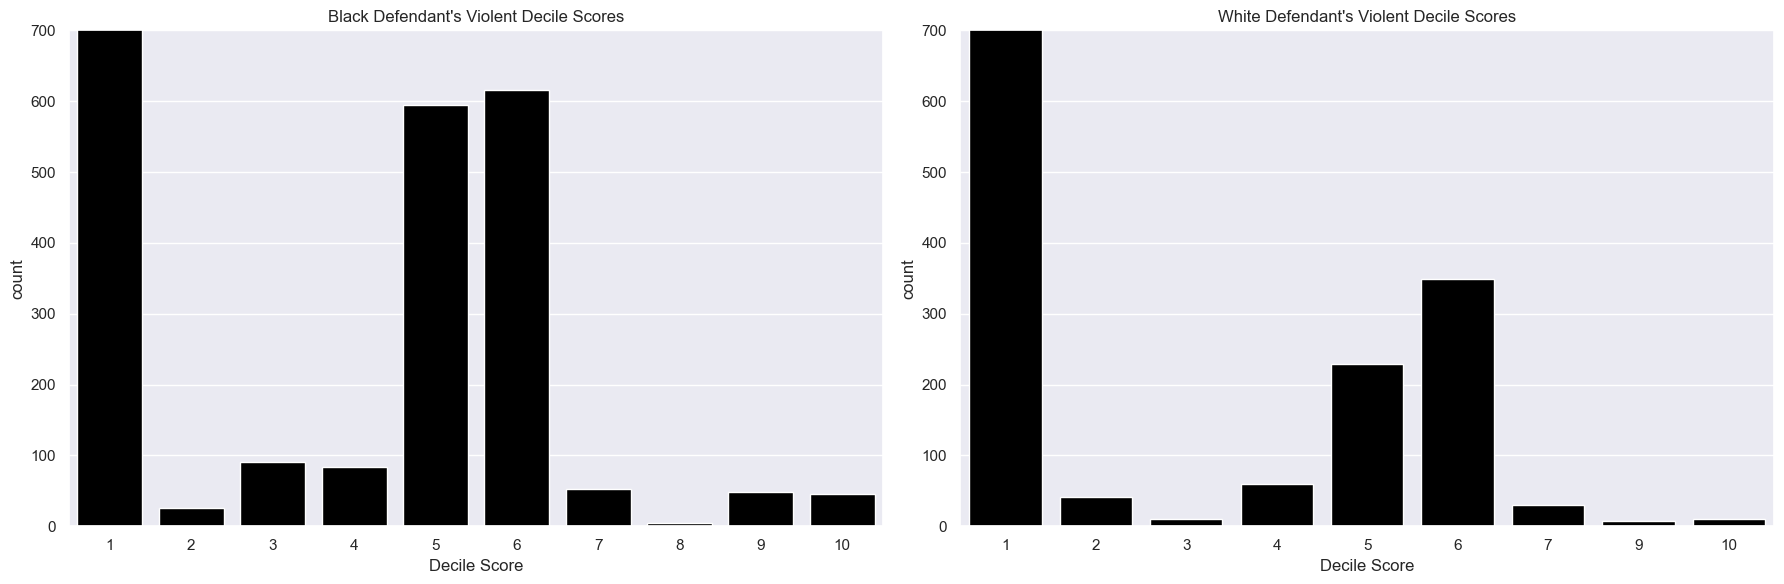

In [90]:


fig, axes = plt.subplots(ncols=2, figsize=(18, 6))

sns.countplot(data=black_df, x='DecileScore', ax=axes[0],color='black')
axes[0].set_title("Black Defendant's Violent Decile Scores")
axes[0].set_xlabel("Decile Score")
axes[0].set_ylim(0, 700)

sns.countplot(data=white_df, x='DecileScore', ax=axes[1],color='black')
axes[1].set_title("White Defendant's Violent Decile Scores")
axes[1].set_xlabel("Decile Score")
axes[1].set_ylim(0, 700)

plt.tight_layout()
save_fig("white_vs_black_auto_fcm", tight_layout=True)
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

fs = 20  # Font size

# Helper function to create a DataFrame from PCA data
create_pca_frame = lambda pcd: pd.DataFrame(pcd, columns=[str(x) for x in range(pcd.shape[1])])

# PCA-transformed data frame
pca_frame = create_pca_frame(pca_data)
pca_frame['pred'] = pd.Series(y_pred_auto_fcm)  # Clusters from K-means or Fuzzy C-means

# Scaled data frame (assumed to have the same structure as pca_data)
scaled_frame = create_pca_frame(scaled_df)

# List of column names to be plotted
columns = ['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count', 'priors_count', 
           'days_b_screening_arrest', 'c_charge_degree', 'c_charge_desc', 'r_charge_degree', 
           'r_days_from_arrest', 'r_offense_date', 'violent_recid', 'vr_charge_degree', 
           'vr_offense_date', 'in_custody', 'out_custody', 'event', 'race']

# Loop through variables for plotting
for x, y in zip(range(len(columns)), columns):
    pca_frame['pred'] = scaled_frame[str(x)]

    # Ensure the cluster centers have the same number of features as the PCA input
    centers = kmeans.cluster_centers_[:, :pca.n_features_in_]  # Select the first 18 features

# Now, transform the reduced cluster centers using the fitted PCA model
    pca_centers = pd.DataFrame(pca.transform(centers), columns=['0', '1'])


    # Create a plot for each variable
    plt.figure(figsize=(50, 50))
    plt.title(f'PCA, var={y}', fontsize=fs)

    # Plotting the PCA-transformed data with clusters using seaborn
    sns.scatterplot(x='0', y='1', hue='pred', data=pca_frame, palette='deep', s=100)

    # Plotting the PCA-transformed cluster centers
    plt.scatter(x=pca_centers['0'], y=pca_centers['1'], color='red', marker='+', s=200, label='Centers')

    # Customizing axis labels and title
    plt.xlabel('Principal Component 1', fontsize=fs)
    plt.ylabel('Principal Component 2', fontsize=fs)
    plt.xticks(fontsize=fs)
    plt.yticks(fontsize=fs)

    # Display the plot
    plt.show()